In [11]:
import numpy as np
import matplotlib.pyplot as plt
from jax import config
config.update("jax_enable_x64", True)
from jax import grad, jit, vmap
import jax.numpy as jnp
from gwb.omega_gw_jax import OmegaGWjax
# Set matplotlib parameters
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm, colors
font = {'size': 16, 'family': 'serif'}
axislabelfontsize = 'large'
matplotlib.rc('font', **font)
# matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=16)


In [20]:
kmin, kmax = 5e-5, 1e-2
k_arr = jnp.logspace(np.log10(kmin), np.log10(kmax), 50)

fac = 10
p_arr = jnp.geomspace(kmin/fac,kmax*fac,100)

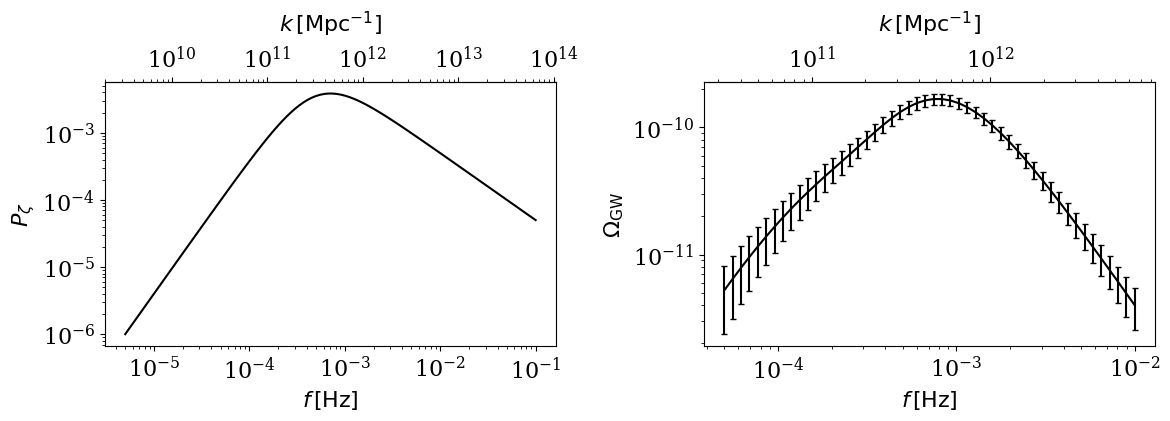

In [3]:
# bpl

f = k_arr #jnp.geomspace(5e-5, 1e-2, ksize)  # The frequencies to calculate Omega_GW
s = jnp.linspace(0, 1,20)  # First rescaled internal momentum
t = jnp.logspace(-5,5, 1000)  # Second rescaled internal momentum

## Expand t to add a new axis
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(f), axis=-1)

@jit
def pz(p,pstar=5e-4,n1=2,n2=-1,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    # osc = (1 + 16.4*jnp.cos(1.4*jnp.log(p/1.))**2)
    return 1e-2 * pl1 * pl2 #*osc

gwb_calculator =  OmegaGWjax(s, t, f=f, kernel="RD", upsample=False)


pz_amp = pz(p_arr)
gwb_amp = gwb_calculator(pz,f)
kstar = 1e-3
omks_sigma = gwb_amp*( 0.05*(np.log(k_arr/kstar))**2 + 0.1) # 2% error at kstar + more towards edges
gwb_cov = jnp.diag(omks_sigma**2)

np.savez("bpl_data.npz", k=k_arr, gw=gwb_amp, cov=gwb_cov, p_arr=p_arr, pz_amp=pz_amp)


fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4.5))
ax1.plot(p_arr,pz_amp,color='k',lw=1.5)
ax1.set_ylabel(r'$P_{\zeta}$')
ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}$')
ax2.plot(f,gwb_amp,color='k',lw=1.5)
ax2.errorbar(f,gwb_amp,yerr=omks_sigma,fmt='none',ecolor='k',capsize=2)
# ax2.fill_between(k_arr,gwb_amp+1.96*omks_sigma,gwb_amp-1.96*omks_sigma,alpha=0.2,color='k')
for ax in [ax1,ax2]:
    ax.set(yscale='log',xscale='log',xlabel=r'$f\,{\rm [Hz]}$')
k_mpc_f_hz = 2*np.pi * 1.03 * 10**14
for x in [ax1,ax2]:
    secax = x.secondary_xaxis('top', functions=(lambda x: x * k_mpc_f_hz, lambda x: x / k_mpc_f_hz))
    secax.set_xlabel(r"$k\,{\rm [Mpc^{-1}]}$",labelpad=10) 
fig.tight_layout()
plt.savefig("bpl_input.pdf")

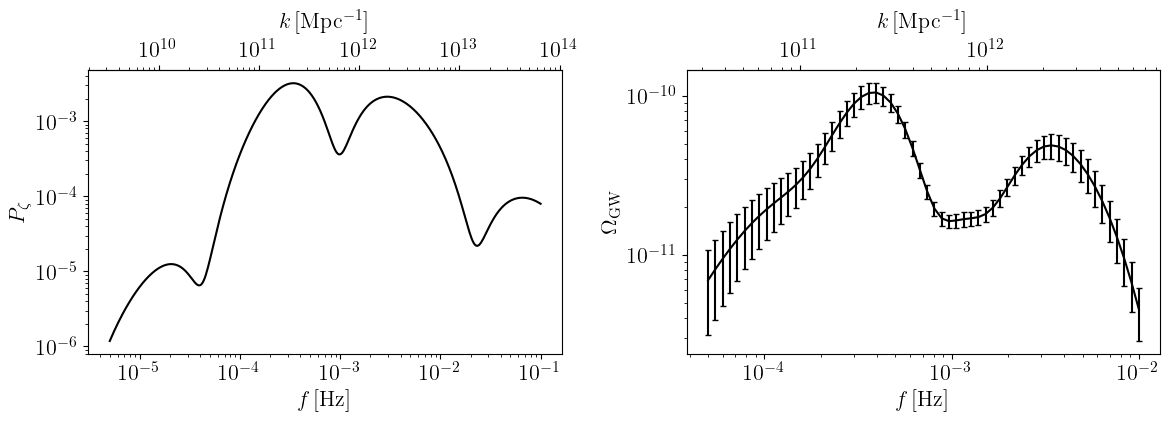

In [6]:
# osc

k_arr = jnp.logspace(np.log10(kmin), np.log10(kmax), 60)

f = k_arr #jnp.geomspace(5e-5, 1e-2, ksize)  # The frequencies to calculate Omega_GW
s = jnp.linspace(0, 1, 20)  # First rescaled internal momentum
t = jnp.logspace(-5,5, 200)  # Second rescaled internal momentum

## Expand t to add a new axis
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(f), axis=-1)

@jit
def pz(p,pstar=5e-4,n1=2,n2=-1,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    # osc = (1 + 16.4*jnp.cos(1.4*jnp.log(p/1.))**2)
    osc = (1 + 15*jnp.cos(1*jnp.log(p/2.5))**2)
    return 1e-3*pl1 * pl2 *osc

gwb_calculator =  OmegaGWjax(s, t, f=f, kernel="RD", upsample=False)


pz_amp = pz(p_arr)
gwb_amp = gwb_calculator(pz,f)
kstar = 1e-3
omks_sigma = gwb_amp*( 0.05*(np.log(k_arr/kstar))**2 + 0.1) # 2% error at kstar + more towards edges
gwb_cov = jnp.diag(omks_sigma**2)

np.savez("osc_data.npz", k=k_arr, gw=gwb_amp, cov=gwb_cov, p_arr=p_arr, pz_amp=pz_amp)



fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4.5))
ax1.plot(p_arr,pz_amp,color='k',lw=1.5)
ax1.set_ylabel(r'$P_{\zeta}$')
ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}$')
ax2.plot(f,gwb_amp,color='k',lw=1.5)
ax2.errorbar(f,gwb_amp,yerr=omks_sigma,fmt='none',ecolor='k',capsize=2)
# ax2.fill_between(k_arr,gwb_amp+1.96*omks_sigma,gwb_amp-1.96*omks_sigma,alpha=0.2,color='k')
for ax in [ax1,ax2]:
    ax.set(yscale='log',xscale='log',xlabel=r'$f\,{\rm [Hz]}$')
k_mpc_f_hz = 2*np.pi * 1.03 * 10**14
for x in [ax1,ax2]:
    secax = x.secondary_xaxis('top', functions=(lambda x: x * k_mpc_f_hz, lambda x: x / k_mpc_f_hz))
    secax.set_xlabel(r"$k\,{\rm [Mpc^{-1}]}$",labelpad=10) 
fig.tight_layout()
plt.savefig("osc_input.pdf")

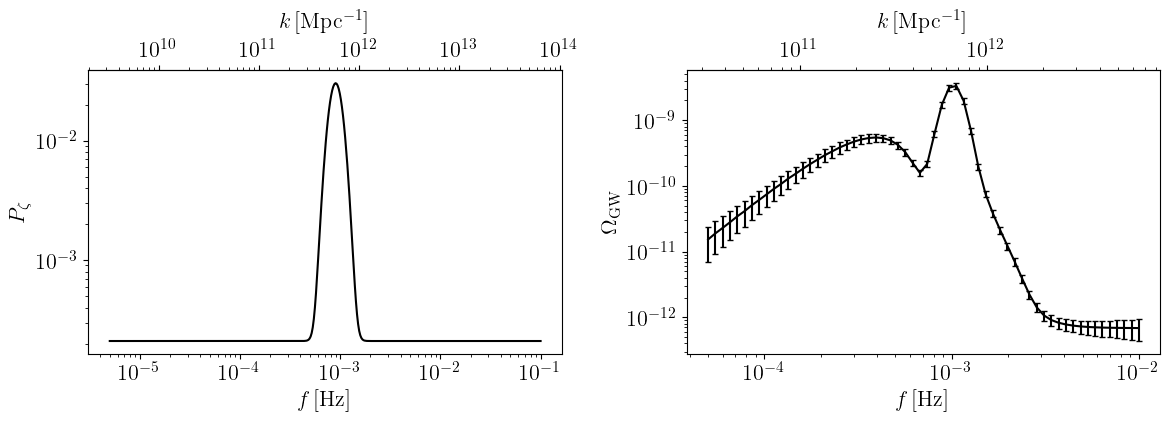

In [6]:

f = k_arr #jnp.geomspace(5e-5, 1e-2, ksize)  # The frequencies to calculate Omega_GW
s = jnp.linspace(0, 1,50)  # First rescaled internal momentum
t = jnp.logspace(-6,6, 1000)  # Second rescaled internal momentum


@jit
def pz(p,pstar=9e-4,sigma=0.15,amp=1e-1,floor=7e-3):
    res = amp *(floor+ jnp.exp(-0.5*((jnp.log(p/pstar)/sigma)**2)))
    return 3e-1*res


pz_amp = pz(p_arr)
gwb_amp = gwb_calculator(pz,f)
kstar = 1e-3
omks_sigma = gwb_amp*( 0.05*(np.log(k_arr/kstar))**2 + 0.1) # 2% error at kstar + more towards edges
gwb_cov = jnp.diag(omks_sigma**2)

np.savez("peaked_data.npz", k=k_arr, gw=gwb_amp, cov=gwb_cov, p_arr=p_arr, pz_amp=pz_amp)



fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4.5))
ax1.plot(p_arr,pz_amp,color='k',lw=1.5)
ax1.set_ylabel(r'$P_{\zeta}$')
ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}$')
ax2.plot(f,gwb_amp,color='k',lw=1.5)
ax2.errorbar(f,gwb_amp,yerr=omks_sigma,fmt='none',ecolor='k',capsize=2)
# ax2.fill_between(k_arr,gwb_amp+1.96*omks_sigma,gwb_amp-1.96*omks_sigma,alpha=0.2,color='k')
for ax in [ax1,ax2]:
    ax.set(yscale='log',xscale='log',xlabel=r'$f\,{\rm [Hz]}$')
k_mpc_f_hz = 2*np.pi * 1.03 * 10**14
for x in [ax1,ax2]:
    secax = x.secondary_xaxis('top', functions=(lambda x: x * k_mpc_f_hz, lambda x: x / k_mpc_f_hz))
    secax.set_xlabel(r"$k\,{\rm [Mpc^{-1}]}$",labelpad=10) 
fig.tight_layout()
plt.savefig("peaked_input.pdf")

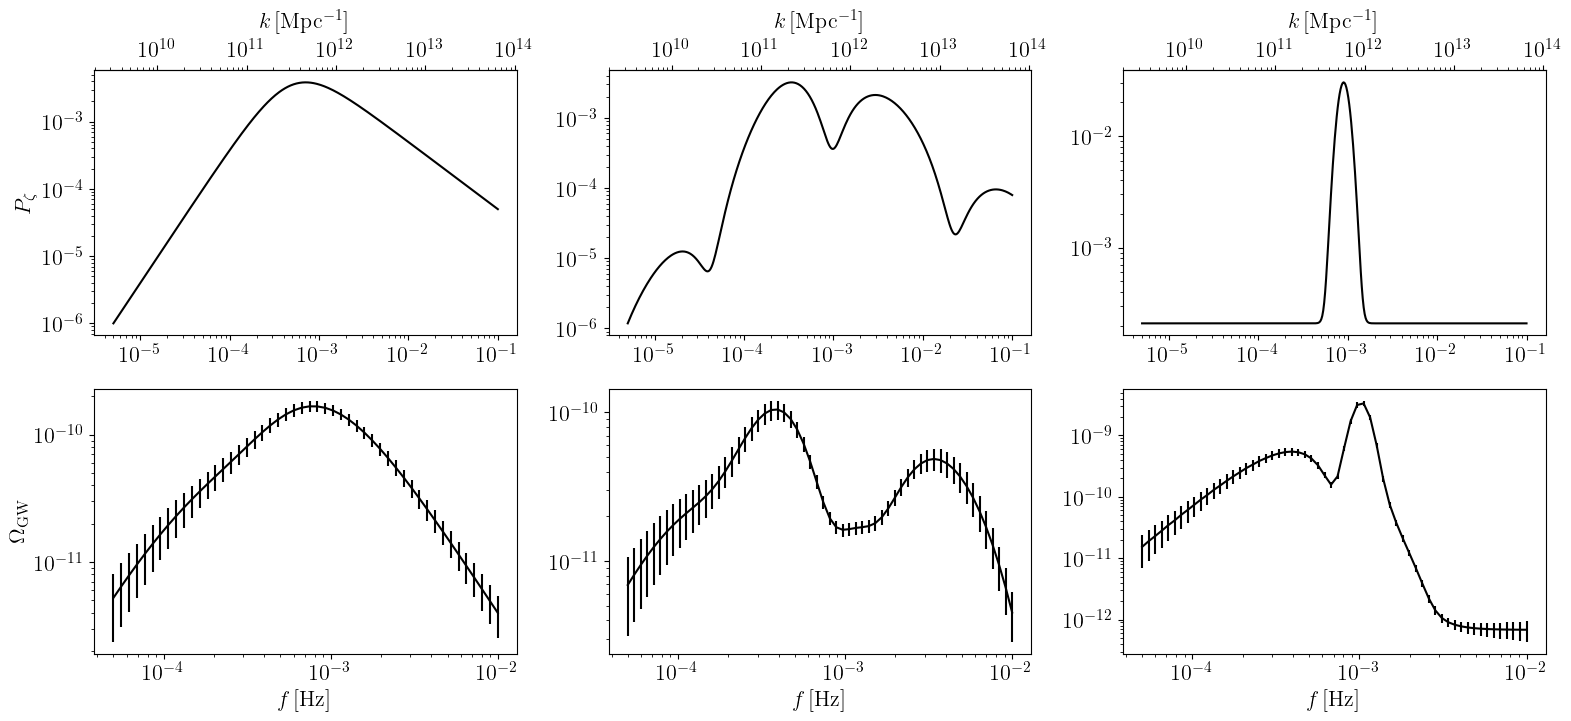

In [7]:
fig,ax = plt.subplots(2,3,figsize=(16,7.5),layout='tight',sharex='row')  
datadir = ['bpl_data.npz','osc_data.npz','peaked_data.npz']


for i in range(3):
    data = np.load(datadir[i])
    k = data['k']
    gw = data['gw']
    cov = data['cov']
    omks_sigma = np.sqrt(np.diag(cov))
    p_arr = data['p_arr']
    pz_amp = data['pz_amp']
    ax[1,i].errorbar(k,gw,yerr=omks_sigma,color='k')
    ax[0,i].loglog(p_arr,pz_amp,color='k')
    # ax[0,i].set_title(['BPL','OSC','PEAKED'][i])
    ax[1,i].set_xscale('log')
    ax[1,i].set_yscale('log')
    ax[1,i].set_xlabel(r'$f\,{\rm [Hz]}$')
ax[0,0].set_ylabel(r'$P_{\zeta}$')
ax[1,0].set_ylabel(r'$\Omega_{\mathrm{GW}}$')

# ax1.plot(p_arr,pz_amp,color='k',lw=1.5)
# ax1.set_ylabel(r'$P_{\zeta}$')
# ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}$')
# ax2.plot(f,gwb_amp,color='k',lw=1.5)
# ax2.errorbar(f,gwb_amp,yerr=omks_sigma,fmt='none',ecolor='k',capsize=2)
# # ax2.fill_between(k_arr,gwb_amp+1.96*omks_sigma,gwb_amp-1.96*omks_sigma,alpha=0.2,color='k')
# for ax in [ax1,ax2]:
#     ax.set(yscale='log',xscale='log',xlabel=r'$f\,{\rm [Hz]}$')
# k_mpc_f_hz = 2*np.pi * 1.03 * 10**14
for x in ax[0,:]:
    secax = x.secondary_xaxis('top', functions=(lambda x: x * k_mpc_f_hz, lambda x: x / k_mpc_f_hz))
    secax.set_xlabel(r"$k\,{\rm [Mpc^{-1}]}$",labelpad=10) 
# fig.tight_layout()
plt.savefig("spectra_input.pdf")

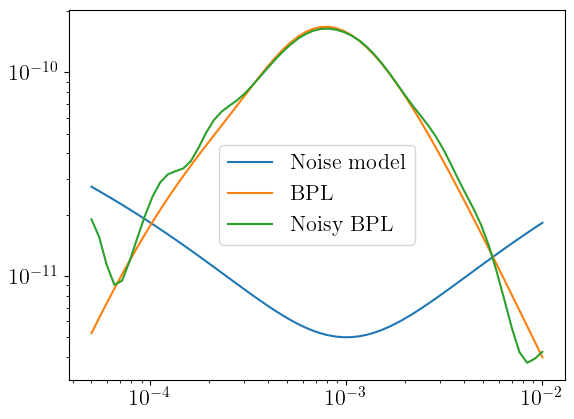

In [ ]:
# noisy spectra

from scipy.ndimage import gaussian_filter1d

np.random.seed(10)

def noise_model(f,fstar=1e-3):
    return np.ones_like(f)*5e-11*( 0.05*(np.log(f/fstar))**2 + 0.1)


frequencies = k


plt.loglog(frequencies,noise_model(frequencies),label='Noise model')

f = k_arr #jnp.geomspace(5e-5, 1e-2, ksize)  # The frequencies to calculate Omega_GW
s = jnp.linspace(0, 1,20)  # First rescaled internal momentum
t = jnp.logspace(-5,5, 1000)  # Second rescaled internal momentum

## Expand t to add a new axis
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(f), axis=-1)

@jit
def pz(p,pstar=5e-4,n1=2,n2=-1,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    # osc = (1 + 16.4*jnp.cos(1.4*jnp.log(p/1.))**2)
    return 1e-2 * pl1 * pl2 #*osc



cov = np.diag(noise_model(frequencies)**2)
gwb_calculator =  OmegaGWjax(s, t, f=f, kernel="RD", upsample=False)
bpl = gwb_calculator(pz,frequencies)
def gen_noisy_data(gwb_model,freqs,cov):
    means = gwb_calculator(gwb_model,freqs)
    return means + np.random.multivariate_normal(np.zeros_like(freqs),cov)

noisy_bpl = gen_noisy_data(pz,frequencies,cov)
noisy_bpl = gaussian_filter1d(noisy_bpl,2)
plt.loglog(frequencies,bpl,label='BPL')
plt.loglog(frequencies,noisy_bpl,label='Noisy BPL')
plt.legend()

In [9]:
@jit
def osc(p,pstar=5e-4,n1=2,n2=-1,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    # osc = (1 + 16.4*jnp.cos(1.4*jnp.log(p/1.))**2)
    osc = (1 + 15*jnp.cos(1*jnp.log(p/2.5))**2)
    return 1e-3*pl1 * pl2 *osc
